# Sparkify Project 
This workspace uses the medium sized dataset (medium-sparkify-event-data.json) on IBM Watson Studio.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix

import os
import re
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

! pip install user_agents
from user_agents import parse

import re

%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200410101553-0000
KERNEL_ID = b563b727-c346-4380-aac7-0a2881196b8b
  Stored in directory: /home/spark/shared/.cache/pip/wheels/99/f3/df/12f8953cef0e59c251c6e9cf7816d202e8e778a3a928a645a6
Successfully built user-agents


In [2]:
# display setting
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

### Spark Session for IBM Watson Studio

In [4]:
# create a Spark session 
spark = SparkSession \
    .builder \
    .appName('Sparkify')\
    .getOrCreate()

In [5]:
# all the parameter of spark Context
# spark.sparkContext.getConf().getAll()

# Load and Clean Dataset
Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
def load_data(path):
    df_raw = spark.read.json(path)
    return df_raw

In [7]:
#path = 'medium-sparkify-event-data.json'
path = cos.url('medium-sparkify-event-data.json', 'sparkipy-donotdelete-pr-ients3mkm9ftps')
df_raw = load_data(path)

In [10]:
df_raw.select('userId').dropDuplicates().sort('userId').show() # an empty space is found here

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [8]:
def clean_data(df_raw):
    '''
    Drop invalid or missing data
    '''
    df = df_raw.dropna(how = 'any', subset = ['userId', 'sessionId'])
    df = df.filter(df['userId'] != '')
    return df

In [9]:
df = clean_data(df_raw)

In [116]:
# check null values in each column
df_agg = df.agg(*[count(when(isnull(c), c)).alias(c) for c in df.columns])
df_agg.show()

+------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+-----+------+------+-----+-------+---+------+---------+-----------+-----------+---------+-------+----------+
|userId|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|Churn|max_ts|tenure|state|browser| os|device|num_songs|num_artists|roll_advert|downgrade|upgrade|thumbsdown|
+------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+-----+------+------+-----+-------+---+------+---------+-----------+-----------+---------+-------+----------+
|     0| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|    0|     0|     0|    0|      0|  0|     0|        0|          0|          0|        0|      0|

In [100]:
df.filter(df.song.isNotNull()).select('page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



- artist, length, song are empty when the page is not 'NextSong'. These are not invalid data.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. 

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [10]:
def create_label(df):
    '''
    Create a column 'Churn' to use as the label for the model. 
    '''
    
    churned_users = df.where(df.page == 'Cancellation Confirmation').select('userId').distinct()
    churned_users_list = list(churned_users.select('userId').toPandas()['userId'])
    df = df.withColumn('Churn', df.userId.isin(churned_users_list))
    
    return df

In [11]:
df = create_label(df)

In [170]:
df.groupby(df.Churn).agg(countDistinct('userId')).show()

+-----+----------------------+
|Churn|count(DISTINCT userId)|
+-----+----------------------+
| true|                    99|
|false|                   349|
+-----+----------------------+



In [29]:
print('{0:.0%} of users have churned'.format(99.0/(99+349)))

22% of users have churned


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [171]:
# first few rows
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293,True
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98,False
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179,False
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179,False
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246,True


### User Attributes

In [172]:
gender = df.groupby(df.Churn, df.gender).agg(countDistinct('userId')).toPandas()

In [173]:
gender.sort_values(by='gender') 

,Churn,gender,count(DISTINCT userId)
0,True,F,45
3,False,F,153
1,False,M,196
2,True,M,54


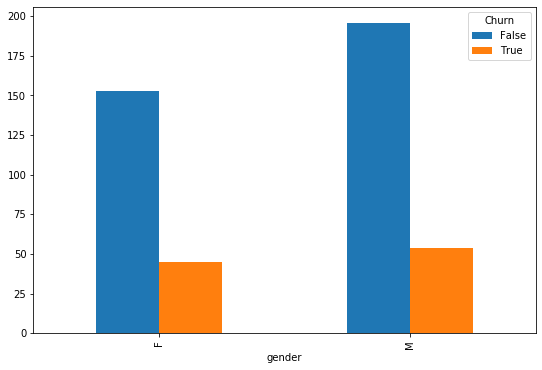

In [175]:
plt.rcParams["figure.figsize"] = (9,6)
gender.pivot(index='gender', columns='Churn', values = 'count(DISTINCT userId)').plot(kind='bar');

- Female users have higher proportion of churn

In [177]:
level = df.groupby(df.Churn, df.level).agg(countDistinct('userId')).toPandas()

In [178]:
level.sort_values(by='level')

,Churn,level,count(DISTINCT userId)
0,False,free,288
3,True,free,82
1,False,paid,246
2,True,paid,75


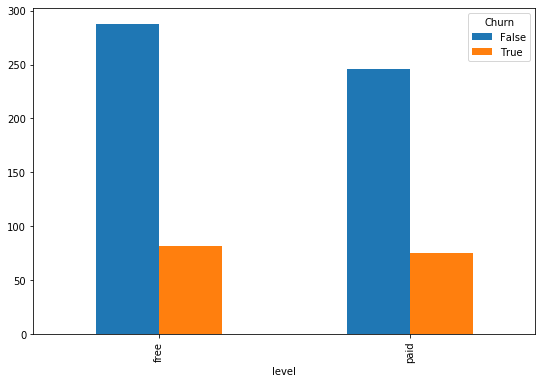

In [179]:
plt.rcParams["figure.figsize"] = (9,6)
level.pivot(index='level', columns='Churn', values = 'count(DISTINCT userId)').plot(kind='bar');

- Paid users have higher proportion of churn than free users

### Activities
- Exploring activitiy-related variables aggregated on label (churn)

In [180]:
df.groupby(df.Churn, df.auth).agg(countDistinct('sessionId')).show()

+-----+---------+-------------------------+
|Churn|     auth|count(DISTINCT sessionId)|
+-----+---------+-------------------------+
| true|Cancelled|                       97|
|false|Logged In|                     3861|
| true|Logged In|                     1072|
+-----+---------+-------------------------+



In [181]:
df.groupby(df.Churn).agg(avg('itemInSession')).show()

+-----+------------------+
|Churn|avg(itemInSession)|
+-----+------------------+
| true| 107.5093008895664|
|false|107.84486484321059|
+-----+------------------+



In [182]:
df.groupby(df.Churn).agg(avg('length')).show()

+-----+------------------+
|Churn|       avg(length)|
+-----+------------------+
| true| 248.9939836060161|
|false|248.58486352452493|
+-----+------------------+



In [183]:
df.groupby(df.Churn, df.method).agg(countDistinct('sessionId')).show()

+-----+------+-------------------------+
|Churn|method|count(DISTINCT sessionId)|
+-----+------+-------------------------+
|false|   PUT|                     3791|
| true|   PUT|                     1046|
|false|   GET|                     3683|
| true|   GET|                     1028|
+-----+------+-------------------------+



In [184]:
page = df.groupby(df.page, df.Churn).agg(countDistinct('sessionId')).sort('page', 'Churn').toPandas()

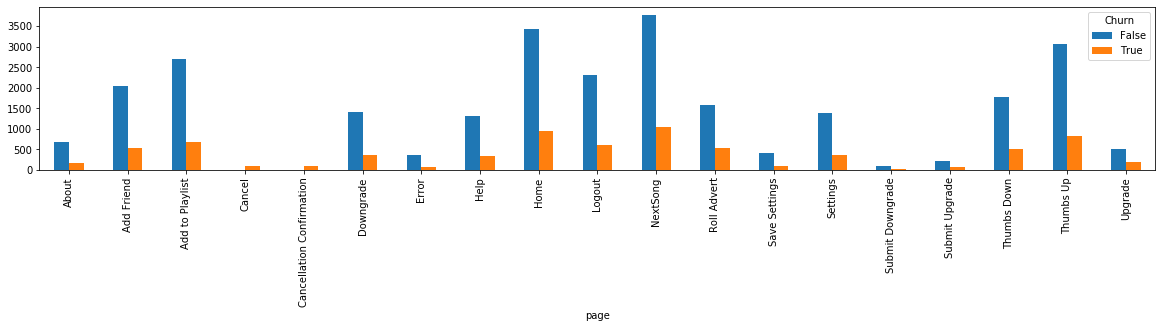

In [185]:
plt.rcParams["figure.figsize"] = (20,3)
page.pivot(index='page', columns='Churn', values = 'count(DISTINCT sessionId)').plot(kind='bar');

In [186]:
pagedf = page.groupby(['page', 'Churn'])['count(DISTINCT sessionId)'].sum()
page_pcts = pagedf.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [187]:
page_pcts

page                       Churn
About                      False     81.084337
                           True      18.915663
Add Friend                 False     79.658385
                           True      20.341615
Add to Playlist            False     79.591232
                           True      20.408768
Cancel                     True     100.000000
Cancellation Confirmation  True     100.000000
Downgrade                  False     79.431818
                           True      20.568182
Error                      False     81.431767
                           True      18.568233
Help                       False     79.854369
                           True      20.145631
Home                       False     78.470320
                           True      21.529680
Logout                     False     79.030595
                           True      20.969405
NextSong                   False     78.337479
                           True      21.662521
Roll Advert                

- Difficult to see a clear relationship between visited page and churn
- Roll Avert, Submit Downgrade/Upgrade, Thumbs down, Upgrade seem to have stronger relationship with Churn than other page visits

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [12]:
## Functions for feature engineering  

def generate_int_label(df):
    df = df.withColumn('label', df['Churn'].cast(IntegerType()))
    return df

def calculate_tenure(df):
    '''
    Calculate tenure: the last interacted date - registration date
    '''
    max_ts_df = df.groupBy('userId').agg(max('ts').alias('max_ts'))
    df = df.join(max_ts_df, on=['userId'], how = 'left')
    df = df.withColumn('tenure', ((df.max_ts-df.registration)/86400000).cast(IntegerType()))    
    
    return df

def create_state_variable(df):
    '''
    Create State from location
    '''
    get_state = udf(lambda x: x.split(',')[1])
    df = df.withColumn('state', get_state(df.location))

    return df

def create_device_variables(df):
    
    get_browser = udf(lambda x: parse(x).browser.family)
    get_os = udf(lambda x: parse(x).os.family)
    get_device = udf(lambda x: parse(x).device.family)
    df = df.withColumn('browser', get_browser(df.userAgent))
    df = df.withColumn('os', get_os(df.userAgent))
    df = df.withColumn('device', get_device(df.userAgent))
    
    return df

def calculate_user_stats(df):
    '''
    Create user level stats
    '''
    w = Window.partitionBy(df.userId)
    df = df.withColumn('num_songs', approx_count_distinct(df.song).over(w))
    df = df.withColumn('num_artists', approx_count_distinct(df.artist).over(w))
    df = df.withColumn('avg_length', avg(df.length).over(w))
    
    return df    

def create_page_variables(df):
    '''
    Based on EDA, create variables indicating if a user visited specific pages
    In addition to the pages that show stronger relationship with churn, 
    we will make variables for Add Friend and Add to Playlist page visits
    '''
    
    RollAdvert = df.where(df.page == 'Roll Advert').select('userId').distinct()
    RollAdvert_list = list(RollAdvert.select('userId').toPandas()['userId'])
    df = df.withColumn('roll_advert', df.userId.isin(RollAdvert_list))
    
    Downgrade = df.where(df.page == 'Submit Downgrade').select('userId').distinct()
    Downgrade_list = list(Downgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('downgrade', df.userId.isin(Downgrade_list))
    
    Upgrade = df.where(df.page == 'Submit Upgrade').select('userId').distinct()
    Upgrade_list = list(Upgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('upgrade', df.userId.isin(Upgrade_list))
   
    Thumbsdown = df.where(df.page == 'Thumbs Down').select('userId').distinct()
    Thumbsdown_list = list(Thumbsdown.select('userId').toPandas()['userId'])
    df = df.withColumn('thumbsdown', df.userId.isin(Thumbsdown_list))
    
    AddFriend = df.where(df.page == 'Add Friend').select('userId').distinct()
    AddFriend_list = list(AddFriend.select('userId').toPandas()['userId'])
    df = df.withColumn('addfriend', df.userId.isin(AddFriend_list))
    
    AddtoPlaylist = df.where(df.page == 'Add to Playlist').select('userId').distinct()
    AddtoPlaylist_list = list(AddtoPlaylist.select('userId').toPandas()['userId'])
    df = df.withColumn('addtoplaylist', df.userId.isin(AddtoPlaylist_list))
    
    return df

In [13]:
df = generate_int_label(df)
df = calculate_tenure(df)
df = create_state_variable(df)
df = create_device_variables(df)
df = calculate_user_stats(df)
df = create_page_variables(df)

In [17]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,Churn,label,max_ts,tenure,state,browser,os,device,num_songs,num_artists,avg_length,roll_advert,downgrade,upgrade,thumbsdown,addfriend,addtoplaylist
0,100010,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Sandstorm,200,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",True,1,1539254318000,14,CT,Mobile Safari,iOS,iPhone,99,92,269.48907,True,False,False,True,True,True
1,100010,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Phantom Part 1.5 (Album Version),200,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",True,1,1539254318000,14,CT,Mobile Safari,iOS,iPhone,99,92,269.48907,True,False,False,True,True,True
2,100010,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Canada,200,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",True,1,1539254318000,14,CT,Mobile Safari,iOS,iPhone,99,92,269.48907,True,False,False,True,True,True
3,100010,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Ticket To Ride,200,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",True,1,1539254318000,14,CT,Mobile Safari,iOS,iPhone,99,92,269.48907,True,False,False,True,True,True
4,100010,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Dismissed (Uffie),200,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",True,1,1539254318000,14,CT,Mobile Safari,iOS,iPhone,99,92,269.48907,True,False,False,True,True,True


In [14]:
def drop_columns(df):
    '''
    Drop unnecessary columns before modeling
    '''
    columns_to_drop = ['userId', 'artist', 'auth', 'firstName', 'itemInSession', 'lastName', 'length', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status',
                       'ts', 'userAgent', 'max_ts', 'Churn']
    
    df = df.drop(*columns_to_drop) 
    
    return df

In [15]:
df_model = drop_columns(df)

In [18]:
pd.DataFrame(df_model.orderBy(rand()).take(5), columns=df_model.columns)

,gender,level,label,tenure,state,browser,os,device,num_songs,num_artists,avg_length,roll_advert,downgrade,upgrade,thumbsdown,addfriend,addtoplaylist
0,M,paid,0,88,FL,Chrome,Mac OS X,Mac,1761,1349,248.779381,True,False,False,True,True,True
1,F,paid,0,61,KS,IE,Windows,Other,2729,2123,245.290129,True,False,True,True,True,True
2,F,paid,1,63,AL,Firefox,Windows,Other,2579,1870,251.601132,True,True,True,True,True,True
3,M,paid,0,76,TN,Chrome,Mac OS X,Mac,3637,2464,249.914483,True,True,True,True,True,True
4,M,free,0,390,LA,IE,Windows,Other,309,288,254.014158,True,False,False,True,True,True


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Step 1. Train, Test Split (80%, 20%)

In [19]:
train, test = df_model.randomSplit([0.8, 0.2], seed=42)

In [25]:
# get the dimensions of the data
print(train.count(), len(train.columns))
print(test.count(), len(test.columns))

422492 17
105513 17


### Step 2. Build Pipeline - Logistic regression, Random Forest, Gradient-Boosted Trees

In [20]:
# String Indexer for OneHotEncoderEstimator
SI_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
SI_level = StringIndexer(inputCol='level', outputCol='level_index')
SI_state = StringIndexer(inputCol='state', outputCol='state_index')
SI_browser = StringIndexer(inputCol='browser', outputCol='browser_index')
SI_os =  StringIndexer(inputCol='os', outputCol='os_index')
SI_device= StringIndexer(inputCol='device', outputCol='device_index')

# OneHotEncoderEstimator
OHE = OneHotEncoderEstimator(inputCols=['gender_index', 'level_index', 'state_index', 'browser_index', 'os_index', 'device_index'],
                             outputCols=['gender_OHE', 'level_OHE', 'state_OHE', 'browser_OHE', 'os_OHE', 'device_OHE'])

# Create a vector of all numeric features for scaling
num_assembler = VectorAssembler(inputCols=['tenure', 'num_songs', 'num_artists', 'avg_length'], outputCol='NumFeatures')

# Standard scaler for numeric features
scaler = StandardScaler(inputCol='NumFeatures', outputCol='ScaledNumFeatures', withStd=True)

# Create a vector of all features for modeling
feature_assembler = VectorAssembler(inputCols=['ScaledNumFeatures', 'gender_OHE', 'level_OHE', 'state_OHE', 'browser_OHE', 'os_OHE', 'device_OHE', 
                                              'roll_advert', 'downgrade', 'upgrade', 'thumbsdown', 'addfriend', 'addtoplaylist'], 
                                    outputCol='features')

# Logistic model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_pipeline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, lr])

# Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_pipeline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, rf])

# Gradient.Boosted tree classifier
gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbt_pieline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, gbt])

### Step 3. Training and evaluating the model performance

In [18]:
# training models 
lr_model = lr_pipeline.fit(train)
rf_model = rf_pipeline.fit(train)
gbt_model = gbt_pieline.fit(train)

In [19]:
# obtain predictions
lr_preds = lr_model.transform(test)
rf_preds = rf_model.transform(test)
gbt_preds = gbt_model.transform(test)

### Step 4. Evaluation (AUC and Accuracy)

#### Evaluation with AUC

In [22]:
my_eval = BinaryClassificationEvaluator(labelCol = 'label')

In [24]:
print('AUC for Logistic Regression is {}'.format(my_eval.evaluate(lr_preds)))

AUC for LogisticRegression is 0.8599395675775529


In [25]:
print('AUC for Random Forest is {}'.format(my_eval.evaluate(rf_preds)))

AUC for Random Forest is 0.9084217367834391


In [27]:
print('AUC for Grandient Boosted Tree is {}'.format(my_eval.evaluate(gbt_preds)))

AUC for Grandient Boosted Tree is 0.9928140191724352


#### Evaluation with accuracy

In [28]:
print(lr_preds.filter(lr_preds.label == lr_preds.prediction).count())
print(lr_preds.count())

89944
105513


In [52]:
print('Accuracy for Linear Regression is {}'.format(89944/105513))

Accuracy for Linear Regression is 0.8524447224512619


In [29]:
print(rf_preds.filter(lr_preds.label == rf_preds.prediction).count())
print(rf_preds.count())

88488
105513


In [54]:
print('Accuracy for Random Forest is {}'.format(88488/105513))

Accuracy for Random Forest is 0.8386454749651702


In [30]:
print(gbt_preds.filter(lr_preds.label == gbt_preds.prediction).count())
print(gbt_preds.count())

101481
105513


In [56]:
print('Accuracy for Gradient Boosted Tree is {}'.format(101481/105513))

Accuracy for Gradient Boosted Tree is 0.9617866992692844


#### Confusion matrix for the best model

In [34]:
## Confusion matrix for gbt
y_true = gbt_preds.select(['label']).collect()
y_pred = gbt_preds.select(['prediction']).collect()
#y_true_series = pd.Series(y_true)
#y_pred_series = pd.Series(y_pred)
#pd.crosstab(y_true_series, y_pred_series, rownames=['True'], colnames=['Predicted'], margins=True)

In [36]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     84867
           1       1.00      0.81      0.89     20646

   micro avg       0.96      0.96      0.96    105513
   macro avg       0.98      0.90      0.93    105513
weighted avg       0.96      0.96      0.96    105513



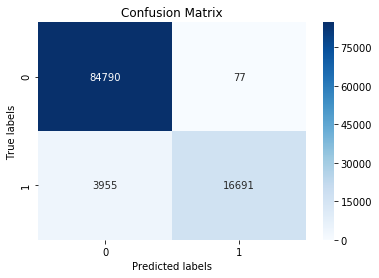

In [87]:
ax = plt.subplot()
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, ax = ax, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Step 5. Code for Hyper Parameter Tuning 

In [25]:
# Set the Parameters grid
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [3, 5, 7])  
                 .addGrid(gbt.maxBins, [20, 60]) 
                 .addGrid(gbt.maxIter, [10, 20]) 
                 .build())

gbt_cv = CrossValidator(estimator=gbt_pieline, estimatorParamMaps=gbt_paramGrid, 
                        evaluator=my_eval, numFolds = 3)

In [27]:
cvModel = gbt_cv.fit(train)

In [ ]:
cvResults = cvModel.transform(test)

In [ ]:
print('AUC for Grandient Boosted Tree from Cross Validation is {}'.format(my_eval.evaluate(cvResults)))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.